In [16]:
import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from bqplot import pyplot as blt
import scipy.integrate as si
import scipy.interpolate as st
import scipy.io as sco
from ipywidgets import interact, IntSlider

import sklearn as sk
from sklearn import svm
from sklearn import neighbors

import os
import threading

import glob
import collections

import sympy as sp
from sympy import symbols
sp.init_printing()

matplotlib.style.use('ggplot')

%pylab inline

pylab.rcParams['figure.figsize'] = (32, 16)

Populating the interactive namespace from numpy and matplotlib


# 1. Of the accounts without services, which should be prioritized?

In [42]:
# Customer Account Details
sheet1 = pd.read_excel('./Tranzact Accounts - For CU.xlsx')
display(sheet1.head())

,Name/ID,Vertical,Industry,Total BRR Currency,Total BRR
0,10015,Internet Content & Software,Media & Content,USD,1020
1,10034,Consulting / Other Professional Services,Professional Services,USD,2116
2,10168,VOIP/VSP,Telecommunications,USD,0
3,10255,Internet Content & Software,Media & Content,USD,1266
4,10263,Internet Content & Software,Media & Content,USD,301


In [43]:
# Customer Account Services
sheet2 = pd.read_excel('./Tranzact Accounts - For CU.xlsx', sheetname=1)
display(sheet2.head())

,Name/ID,Service Name,Number of Services,Bandwidth,Product,State A,State Z,Service Status,Term,Total MRR
0,10015,275926,1,100Mb,DIA,MD,NaN,Pending Change,12,1102.83
1,10034,286958,3,FE (Cat5),Interconnect,CA,CA,Active,24,50.00
2,10034,283899,3,NaN,Colocation,CA,NaN,Active,24,1450.00
3,10034,284564,3,20Mb,DIA,NaN,NaN,Active,24,616.00
4,10255,214253,4,NaN,Colocation,NV,NaN,Active,12,1178.91


In [44]:
# Customer Account - No Services
sheet3 = pd.read_excel('./Tranzact Accounts - For CU.xlsx', sheetname=2)
display(sheet3.head())

,Name/ID,Vertical,Industry,EmployeeQuantityGrowthRate,SalesTurnoverGrowthRate,PriorYearEmployees,PriorYearRevenue,SalesVolume,SmallBusiness
0,10168,VOIP/VSP,Telecommunications,0.000000,0.000000,3,197123.889000,1.971239e+05,Y
1,10301,Media,Media & Content,0.000000,0.000000,70,0.000000,1.092843e+06,Y
2,10329,Real Estate / Construction,Other Enterprise,0.157143,0.322514,70,15635647.410884,2.067837e+07,N
3,10492,Cloud Service Provider,Data Center & Cloud Services,0.000000,0.073722,55,6439380.374000,6.914106e+06,Y
4,10565,Higher Education,Research & Education,0.000000,-0.073995,455,0.000000,1.241908e+08,N


In [47]:
sheet3.sort_values('PriorYearRevenue', ascending=False).head(n=10)

,Name/ID,Vertical,Industry,EmployeeQuantityGrowthRate,SalesTurnoverGrowthRate,PriorYearEmployees,PriorYearRevenue,SalesVolume,SmallBusiness
381,58220,Healthcare,Healthcare,0.000000,0.023412,127724,7.611610e+10,7.789810e+10,0
343,53524,Manufacturing,Energy & Manufacturing,0.003774,0.019043,53000,7.501221e+10,7.644070e+10,N
242,40224,Retail,Other Enterprise,-0.212851,-0.137891,249000,4.755680e+10,4.099914e+10,N
447,66476,Research,Research & Education,-0.105000,0.074266,20000,2.454324e+10,2.636598e+10,N
413,61928,Health Insurance,Healthcare,0.046351,0.267316,7659,1.452638e+10,1.840951e+10,N
81,21104,Manufacturing,Energy & Manufacturing,-0.058824,-0.098564,22100,1.417570e+10,1.277849e+10,N
616,83705,Manufacturing,Energy & Manufacturing,0.000000,0.044088,31000,1.106154e+10,1.154923e+10,N
524,73978,Transportation,Other Enterprise,0.058824,0.034192,28900,8.435963e+09,8.724406e+09,N
254,41795,Manufacturing,Energy & Manufacturing,-0.049180,0.006061,18300,7.480852e+09,7.526190e+09,N
450,67015,Transportation,Other Enterprise,0.000000,-0.654522,25000,6.359085e+09,2.196925e+09,N


This ordering shows the customers without accounts, but who also have a large revenue. This is straightforward, as companies with more money are more desirable.

# 2. If Zayo sent quotes to all Tranzact accounts, how would you prioritize the customer account list?

Let's assume that we want quote customers that have a larger amount of services, but also have long term contracts.

In [137]:
sheet2.sort_values(['Number of Services', 'Term'], ascending=False)['Name/ID'].unique()[:20]

array([81865, 34531, 75898, 64397, 94103, 72163, 24653, 93352, 14848,
       70236, 84317, 61903, 32934, 77075, 15783, 18254, 22406, 17356,
       99902, 42413])

# 3. If Zayo only had 5 representatives, which states would you prioritize for in person meetings?

In [48]:
A_labels, A_values = zip(*collections.Counter(sheet2['State A']).items())
A_ixs = np.arange(len(A_labels))
Z_labels, Z_values = zip(*collections.Counter(sheet2['State Z']).items())
Z_ixs = np.arange(len(Z_labels))
width = 1

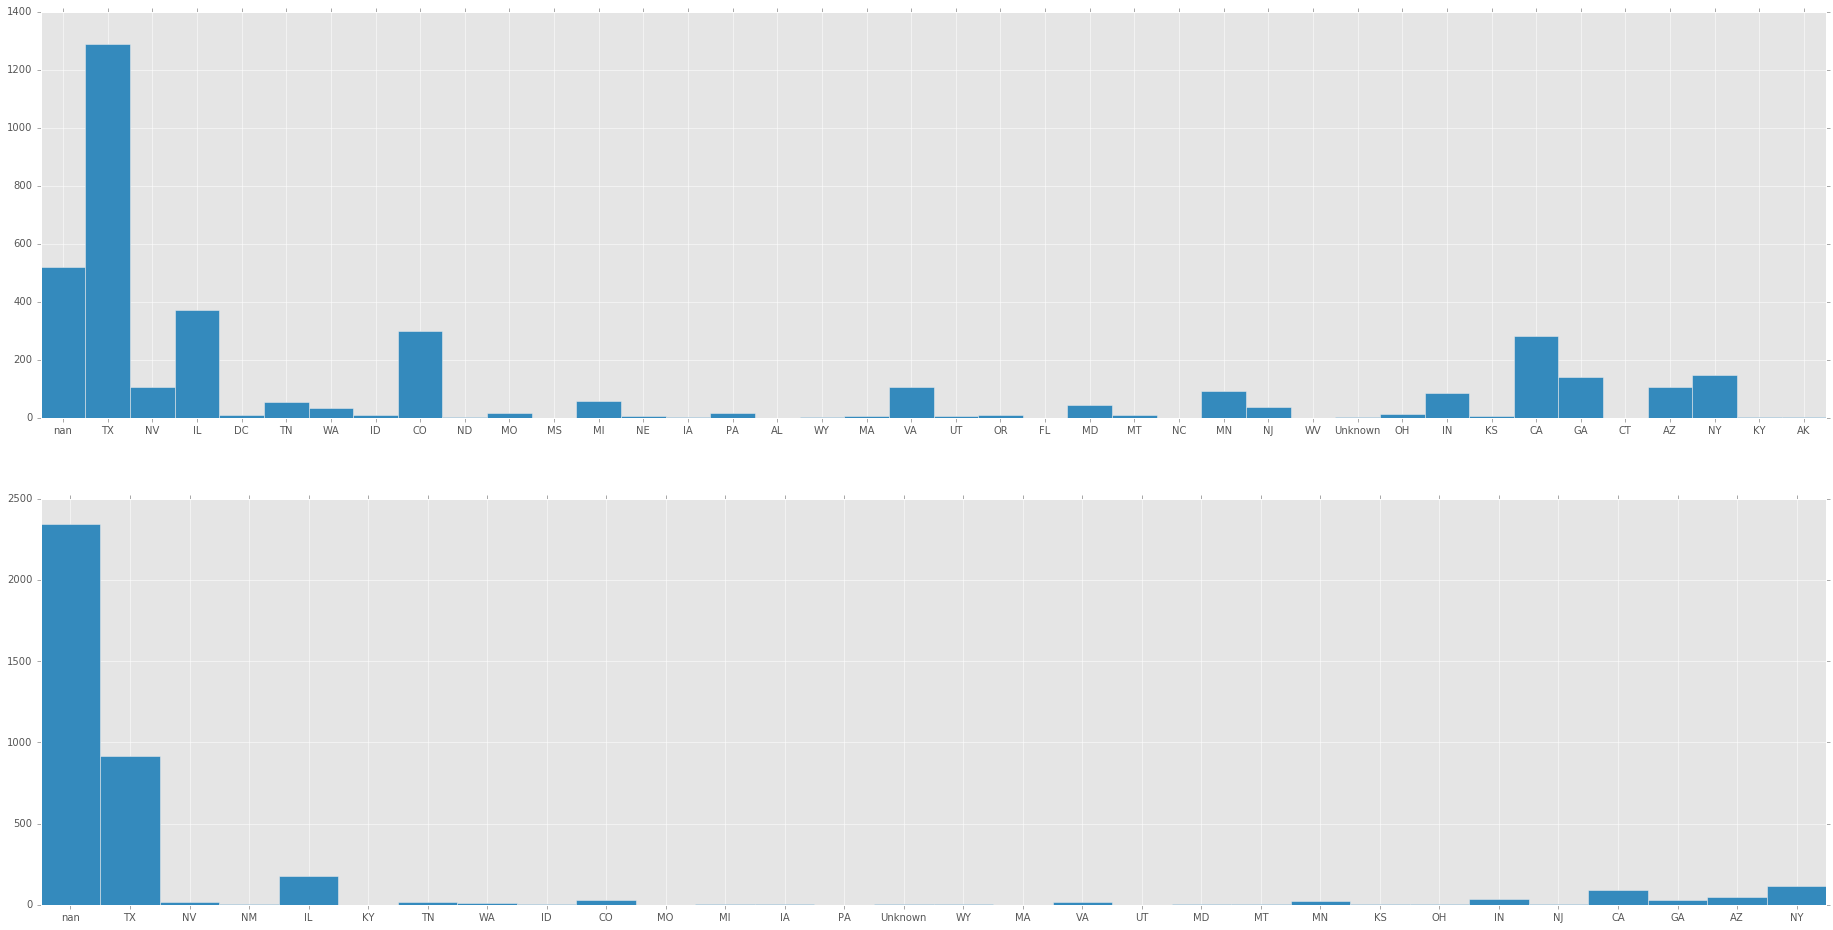

In [49]:
fig, axarr = plt.subplots(2, 1)
axarr[0].bar(A_ixs, A_values, width)
axarr[0].set_xticks(A_ixs + width * 0.5)
axarr[0].set_xticklabels(A_labels)
axarr[1].bar(Z_ixs, Z_values, width)
axarr[1].set_xticks(Z_ixs + width * 0.5)
axarr[1].set_xticklabels(Z_labels)
plt.show()

Based on this graph, the top 5 should be (in this order)

1. Texas
2. Illinois
3. Colorado
4. California
5. New York

# 4. If Zayo only had enough team members to focus on two products, which products would you prioritize? 

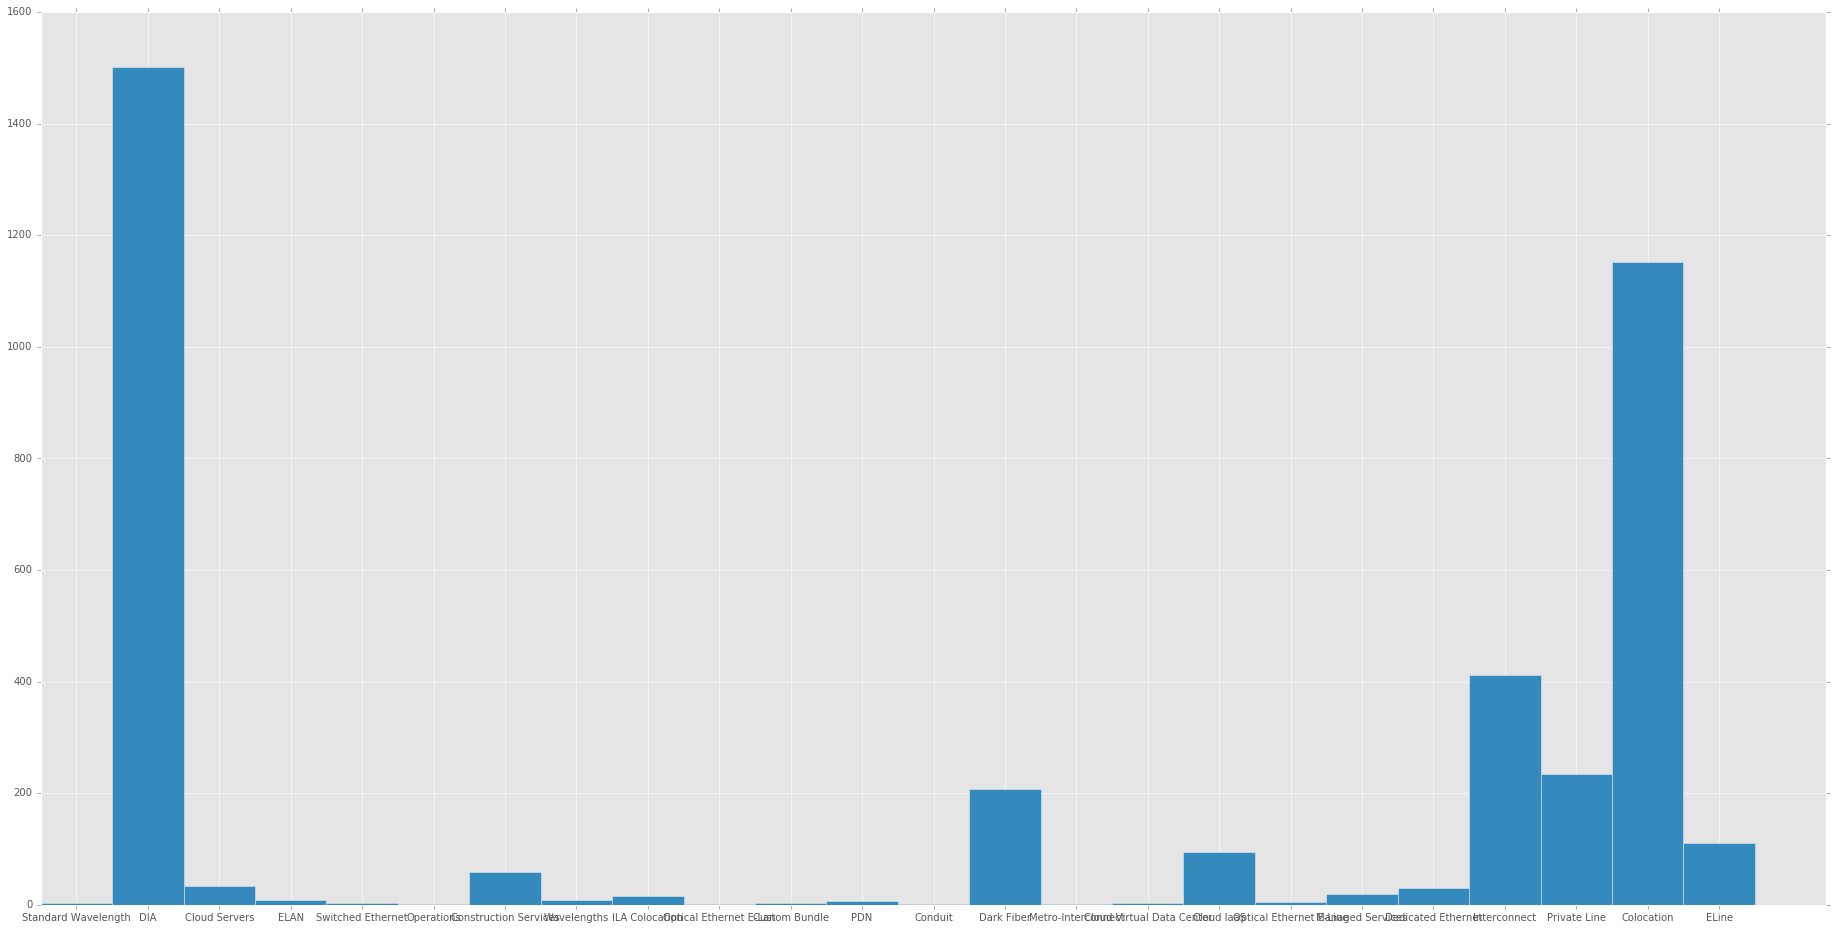

In [50]:
labels, values = zip(*collections.Counter(sheet2['Product']).items())
ixs = np.arange(len(labels))
plt.figure()
plt.bar(ixs, values, width)
plt.xticks(ixs + width * 0.5, labels)
plt.show()

Based on this plot, they should focus on DIA and Colocation.

# 5. Of the Tranzact accounts that have services: What industries/verticals spend the most money and on what products/services? 

In [100]:
industry_data = {}
for key, value in sheet1.groupby('Industry'):
    industry_data[key] = {}
    ids = value['Name/ID'].values
    for i in ids:
        for row in sheet2[sheet2['Name/ID'] == i][['Product', 'Total MRR']].values:
            try:
                industry_data[key][row[0]] += row[1]
            except KeyError:
                industry_data[key][row[0]] = row[1]

An example row below:

In [101]:
industry_data['Healthcare']

{'Cloud IaaS': 6246.4400000000005,
 'Colocation': 27952.319999999996,
 'DIA': 22629.780000000002,
 'Dark Fiber': 4163.7300000000005,
 'Dedicated Ethernet': 2392.9,
 'ELine': 7710.29,
 'Interconnect': 2575.0}

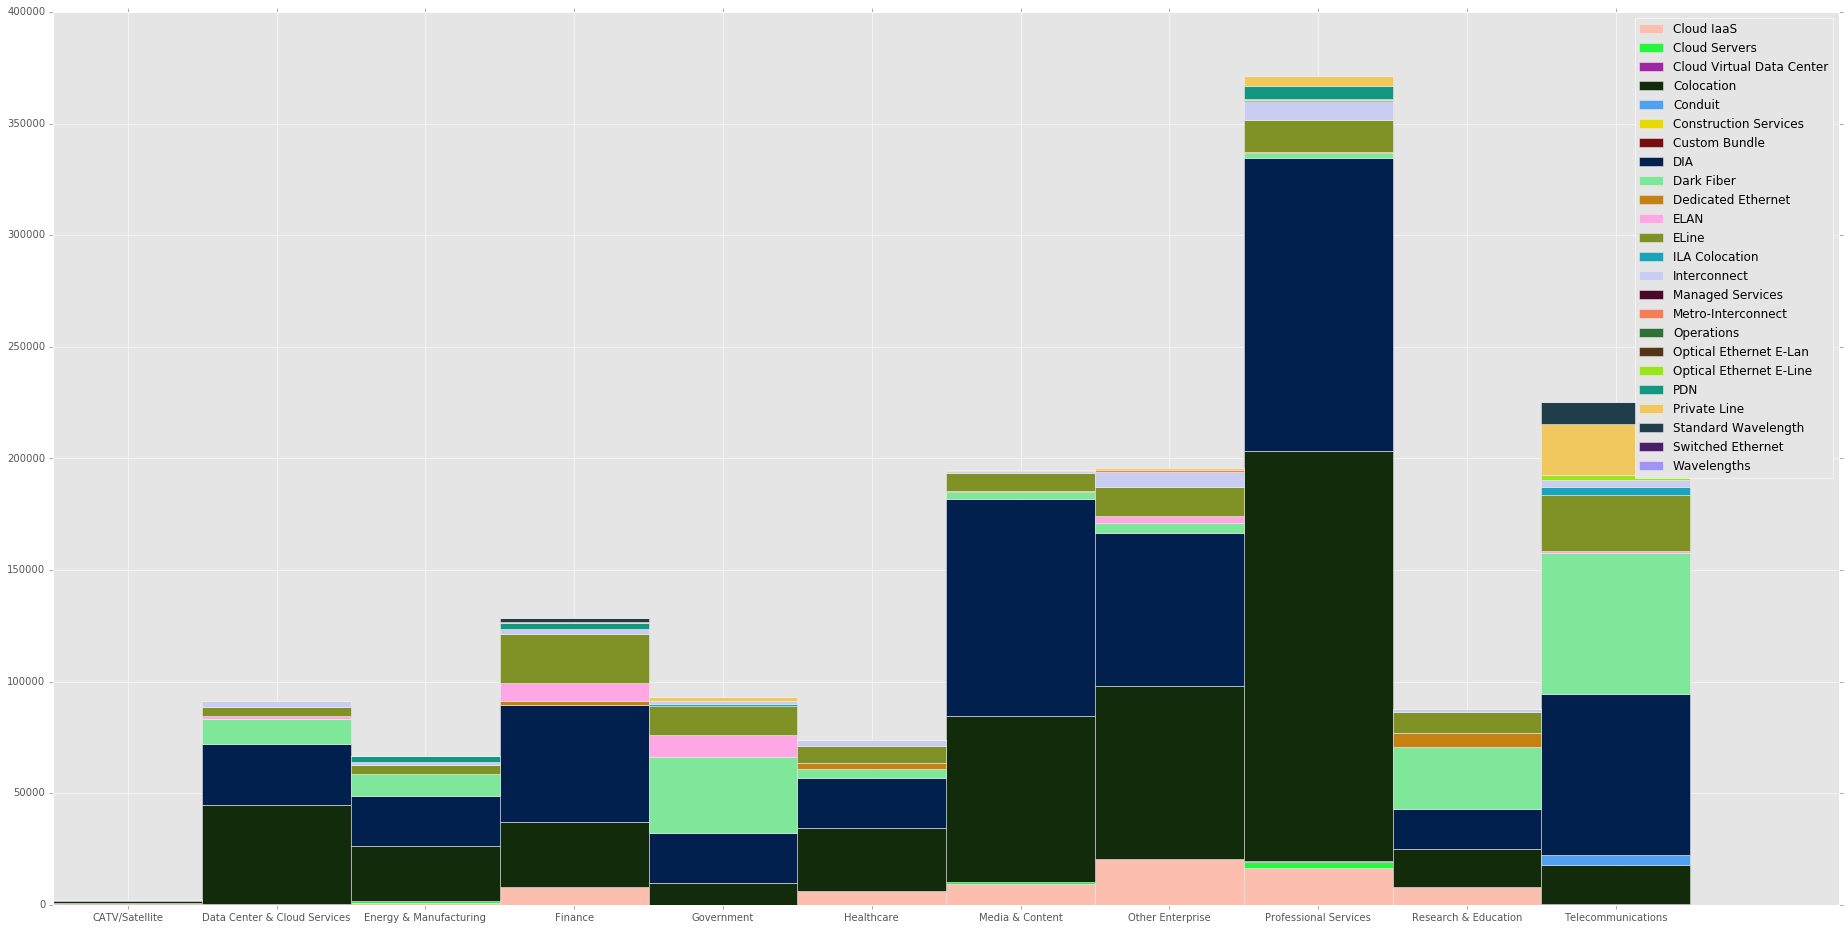

In [128]:
labels = sorted(list(industry_data.keys()))
products = sorted(sheet2['Product'].unique())
bar_heights = {p:np.zeros(len(labels)) for p in products}
ix = np.arange(len(labels))
width = 1
for i in range(len(labels)):
    for p in products:
        try:
            bar_heights[p][i] += industry_data[labels[i]][p]
        except KeyError:
            pass
totals = np.zeros(len(labels))
bars = []
# http://tools.medialab.sciences-po.fr/iwanthue/index.php
colors = ["#FCBEAE", "#27F53E", "#9E26A5", "#112B0B",
            "#50A1F2","#E7DA03","#760E12","#01204E",
            "#7FE79A","#C68113","#FFA6E4","#809225",
            "#19A4BB","#C9CDF1","#4A0828",
            "#F47E57","#307138","#553517","#99E71B",
            "#119782","#F1C85D","#1F3D4B","#4C1D68",
            "#A194F7","#CA1A93","#0BC339","#2DF795",
            "#203C7E","#F79F5E"]
plt.figure()
for i in range(len(products)):
    bars.append(plt.bar(ix, bar_heights[products[i]], width, bottom=totals, color=colors[i]))
    totals += bar_heights[products[i]]
plt.xticks(ix + width * 0.5, labels)
plt.legend(bars, products)
plt.show()

Professional Services spend the most money overall, and they spend it primarily on Colocation, followed by DIA.